## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 3
### Prowadzący: Michał Kempka, Marek Wydmuch
### Autor: Max Adamski, nr indeksu 136674, grupa 16:50

In [ ]:
#!pip install open_spiel
#!pip install gym[box2D]

## Wprowadzenie do Zadania 1

Zadanie będzie polegało na implementacji algorytmu Deep Deterministic Policy Gradient (DDPG) dla środowiska `LunarLanderContinuous` z biblioteki OpenAI Gym (https://gym.openai.com).

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [5]:
import gym
import matplotlib.pylab as plt
from IPython import display
import pandas as pd
%matplotlib inline

class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

def plot_rewards(rewards, eps, roll):
    display.clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(14,8))
    ax.margins(x=0)
    ax.plot(rewards)
    ax.plot(pd.Series(rewards).rolling(roll).mean())
    ax2 = ax.twinx()
    ax2.plot(eps, label='sigma', color='k')
    ax2.legend(loc='lower left')
    ax2.grid(False)
    ax2.set_ylim(0, 1)
    plt.show()
    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000, target=None, target_window=None):
    rewards = []
    sigma = []
    roll = target_window or 50
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation
        rewards.append(total_reward)
        sigma.append(agent.sigma)
        
        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards, sigma, roll)
            
        if plot and  target is not None and len(rewards) > target_window and np.mean(rewards[-target_window:]) > target:
            print('early stopping...')
            plot_rewards(rewards, sigma, roll)
            break
    return rewards    

def test_agent(env, agent, epochs, render=False):
    import seaborn as sns
    render = render or epochs <= 5
    scores = []
    for _ in range(epochs):
        observation = env.reset()
        score = 0
        for _ in range(500):
            if render: env.render()
            action = agent.get_action(observation, learning=False)
            observation, reward, done, _ = env.step(action)
            score += reward
            if done: break
        scores.append(score)
        if render: env.close()
    plt.subplots()
    plt.hist(scores, label='scores'); plt.xlabel('score')
    plt.axvline(np.mean(scores), color='k', label='mean')
    plt.legend(loc='upper right')
    print('mean score', np.mean(scores))

## Zad 1 - Deep Deterministic Policy Gradient (10pkt)

W komórkach poniżej zaimplementuj Deep Deterministic Policy Gradient dla środowiska `LunarLanderContinuous` z eksploracją opartą o dodawanie szumu Gaussowskiego, a jako aproksymatorów użyj prostych sieci neuronowych zaimplementowanych z wykorzystaniem biblioteki PyTroch.

Uwagi:
- Dobra polityka powina mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj by domyślnie Twoja implemnetacja działałą na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architektuę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.

#### Uwaga: nie zmieniaj nazwy klasy `DDPGAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komórki z klasą innego kodu.

In [115]:
import numpy as np
import torch as T
import torch.nn.functional as F
from copy import deepcopy

device = T.device('cuda:0')
rng = np.random.default_rng()

class QModel(T.nn.Module):
    def __init__(self, layers, tanh_output=False):
        super().__init__()
        model = T.nn.Sequential()
        n = len(layers)
        for i in range(1, n):
            model.add_module(f'Linear{i}', T.nn.Linear(layers[i-1], layers[i]))
            if i < n - 1:
                model.add_module(f'Activation{i}', T.nn.ReLU())
        if tanh_output:
            model.add_module(f'ActivationOutput', T.nn.Tanh())
        self.model = model

    def forward(self, x):
        x = x.float()
        return self.model(x)
    
class ReplayMemory:
    def __init__(self, state_width, action_width, capacity):
        self.idx, self.len, self.cap = 0, 0, capacity
        self.A = T.zeros((capacity, action_width)).to(device)
        self.R = T.zeros(capacity).to(device)
        self.S, self.S_next = T.zeros((2, capacity, state_width)).to(device)
        self.S_term = T.zeros(capacity).to(device)
    
    def add(self, a, r, s, s_next, s_term):
        i = self.idx
        self.A[i], self.R[i], self.S[i], self.S_next[i], self.S_term[i] = a, r, s, s_next, s_term
        self.len = min(self.len + 1, self.cap)
        self.idx = (self.idx + 1) % self.cap
            
    def batch(self, size):
        m = T.randperm(self.len)[:size]
        return self.A[m], self.R[m].unsqueeze(1), self.S[m], self.S_next[m], self.S_term[m].unsqueeze(1)
    
    def __len__(self):
        return self.len

In [128]:
class DDPGAgent(Agent):
    def __init__(self, env, γ=0.99, sigma=0.8, sigma_min=0.1, sigma_decay=0.996, tau=0.01,
                 η=0.0001, hidden=[128, 128], batch_size=128, memory_cap=1_000_000):
        super().__init__(env)
        self.action_min, self.action_max = self.action_space.low, self.action_space.high
        self.γ, self.tau, self.sigma, self.sigma_min, self.sigma_decay = γ, tau, sigma, sigma_min, sigma_decay
        self.step = 0
        
        self.inputs = inputs = env.observation_space.shape[0]
        self.outputs = outputs = env.action_space.shape[0]
        
        self.batch_size = batch_size
        self.memory = ReplayMemory(inputs, outputs, memory_cap)
        
        self.actor = QModel([inputs, *hidden, outputs], tanh_output=True).to(device)
        self.critic = QModel([inputs + outputs, *hidden, 1]).to(device)
        self.actor_target = deepcopy(self.actor).to(device)
        self.critic_target = deepcopy(self.critic).to(device)
        self.actor_optim = T.optim.Adam(self.actor.parameters(), lr=η)
        self.critic_optim = T.optim.Adam(self.critic.parameters(), lr=0.001)
        self.loss = T.nn.MSELoss()
    
    def process_transition(self, observation, action, reward, next_observation, done):
        a, r, s, s_next, s_term = T.tensor(action).to(device), reward, T.tensor(observation).to(device), T.tensor(next_observation).to(device), T.tensor(done).to(device)
        
        self.step += 1
        self.memory.add(a, r, s, s_next, s_term)
        if len(self.memory) < self.batch_size: return
        a, r, s, s_next, s_term = self.memory.batch(self.batch_size)
        
        with T.no_grad():
            a_next = self.actor_target(s_next)
            q_next = self.critic_target( T.hstack((s_next, a_next)) )

        y = r + self.γ * q_next * (1 - s_term)
        Y = self.critic( T.hstack((s, a)) )

        critic_loss = self.loss(y, Y)
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()
        
        actor_loss = -self.critic( T.hstack((s, self.actor(s))) ).mean()
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        if done:
            self.sigma = max(self.sigma_min, self.sigma*self.sigma_decay)
        
        for p_target, p in zip(self.actor_target.parameters(), self.actor.parameters()):
            p_target.data = p.data*self.tau + p_target.data*(1-self.tau)
        for p_target, p in zip(self.critic_target.parameters(), self.critic.parameters()):
            p_target.data = p.data*self.tau + p_target.data*(1-self.tau)
        
    def get_action(self, observation, learning):
        with T.no_grad():
            s = T.tensor(observation).to(device).unsqueeze(0)
            a = self.actor(s)[0].cpu().numpy() + learning*rng.normal(scale=self.sigma, size=self.outputs)
            return np.clip(a, self.action_min, self.action_max)

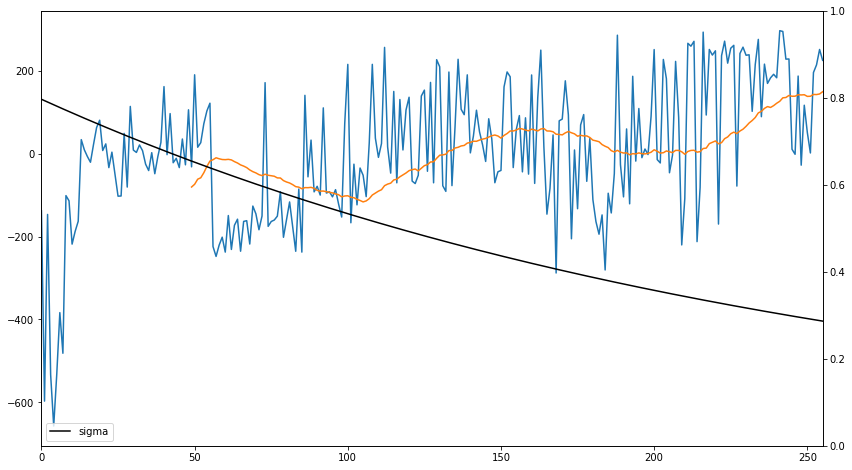

minutes elapsed 20.823973961671193
mean score 196.33850738949823


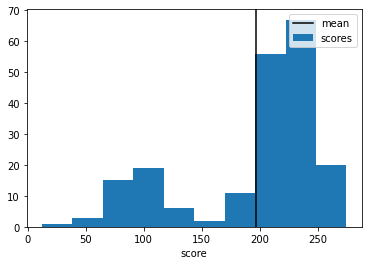

In [131]:
def train_test_agent(env, agent, *, episodes, test_episodes=200, target=150, target_window=50):
    from time import time
    t = time()
    rewards = run_agent_in_env(env, agent, episodes, learning=True, plot=True, target=target, target_window=target_window, plot_interval=5)
    t = time() - t
    print('minutes elapsed', t/60)
    test_agent(env, agent, epochs=test_episodes)

# ale okropnie się uczy...
env = gym.make("LunarLanderContinuous-v2")
agent = DDPGAgent(env)
rewards = train_test_agent(env, agent, episodes=200, target=100)

## Wprowadzenie do Zadania 2

Zadanie będzie polegało na implementacji algorytmu Monte Carlo Tree Search (MCTS) dla środowiska `Connect Four` z biblioteki DeepMind OpenSpiel (https://github.com/deepmind/open_spiel).

In [ ]:
import random
import pyspiel
import numpy as np
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline

class OpenSpielAgent:
    def __init__(self, game):
        self.game = game
        
    def setp(self, state):
        raise NotImplementedError()

def plot_rewards(rewards):
    # NOTE: lepsze rysowanie - nie wypluwamy tony pośrednich wykresów po zakończeniu obliczeń
    display.clear_output(wait=True)
    plt.figure(figsize=(14,6))
    for i, r in enumerate(rewards):
        plt.plot(r, label=f'player {i+1}')
    plt.legend(loc='upper left')
    plt.margins(x=0)
    plt.show()
    
def play_game(game, agents, episodes, plot=False):
    assert len(agents) == game.num_players()
    rewards_history = [[0] for _ in agents]
    for episode in range(episodes):
        state = game.new_initial_state()
        while not state.is_terminal():
            p = (state.current_player() + episode) % game.num_players()
            a = agents[p].step(state.clone())
            try:
                state.apply_action(a)
            except:
                print("Agent selected inlegal action, using random action instead") 
                state.apply_action(np.random.choice(state.legal_actions()))
            
        for i in range(game.num_players()):
            p = (i + episode) % game.num_players()
            rewards_history[i].append(rewards_history[i][-1] + state.player_reward(p))
        
        if plot:
            plot_rewards(rewards_history)

    return rewards_history    

## Zad 2 - Monte Carlo Tree Search (20pkt)

W komórkach poniżej zaimplementuj Agenta używającego Monte Carlo Tree Search dla środowiska `Connect Four`. Użyj losowej polityki rolloutu oraz polityki drzewa opartej o UCB. 

Odpowiedź na pytania:
- Ile stanów posiada środowisko `Connect Four` (ile wierzchołków ma drzewo stanów, możesz policzyć za pomocą komutera).
- Czy widzisz jakiś sprytny sposób na mniejszenie przestrzeni stanów dla gry `Connect Four`? (nie implemnetuj jej).

Uwagi:
- Zadbaj o to by wybór ruch przez Twojego agenta nie trwał dłużej niż 1-2 sekundy.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Agent powinen wygrywać albo remisować większość gier, które rozpoczyna przeciwko innemu silnemu graczowi (np. gotowemu botowi MCTS).

#### Uwaga: nie zmieniaj nazwy klasy `MCTSAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komórki z klasą innego kodu.

**Odpowiedzi**

1. Naiwna górna granica dla ilości wierzchołków w drzewie stanów to $3^{42}$, bo w każdym z 42 pól planszy (dla rozmiaru 7x6) może być nic, kółko gracza 1 lub kółko gracza 2 (3 opcje). Biorąc pod uwagę, że nie wszystkie ułożenia są możliwe (np. kółko, a pod nim wolna przestrzeń), faktycznie drzewo stanów będzie mniejsze. Obliczono, że gra posiada 4531985219092 stanów (źródło: https://oeis.org/A212693). Prostą ale nieefektywną funkcję na obliczenie tego zamieszczam poniżej. Po przepisaniu na mniej elegancką iterację z raportowaniem czasu, okazało się, że obliczenia zajmą ponad rok! Można znacznie przyspieszyć obliczenia, np. 1. równolegle obliczając liczność poddrzew, 2. nie korzystając z open spiel, żeby uniknąć kopiowania stanów podczas chodzenia po drzewie, 3. uwzględniając symetrie stanów, 4. używając szybszego języka.

2. Dla Connect Four można dwukrotnie zmniejszyć przestrzeń stanów, uwzględniając symetrię planszy względem osi Y (obrócenie lewo-prawo).

In [ ]:
def size(state):
    n = 1
    for a in state.legal_actions():
        s = state.clone()
        s.apply_action(a)
        n += size(s)
    return n

#size(game.new_initial_state())

In [ ]:
from math import sqrt, log
from time import time
rng = np.random.default_rng()

def pop_random(xs):
    return xs.pop(rng.integers(len(xs)))

class State:
    __slots__ = 'state player parent action visits value children unexpanded'.split()
    def __init__(self, *, state, player, parent=None, action=None):
        self.state, self.player, self.parent, self.action, self.visits, self.value, self.children = \
            state, player, parent, action, 0, 0, []
        self.unexpanded = state.legal_actions().copy()

    def apply(self, action):
        state = self.state.clone()
        state.apply_action(action)
        return State(state=state, parent=self, action=action, player=1-self.player)

    def best_child(self):
        return max(self.children, key=lambda x: -x.value/x.visits + sqrt(2*log(self.visits)/x.visits))

In [ ]:
class MCTSAgent(OpenSpielAgent):
    def __init__(self, game, max_time=1.5, max_iters=50_000):
        super().__init__(game)
        self.max_time, self.max_iters = max_time, max_iters
    
    def step(self, state):
        t = time()
        root = State(state=state, player=state.current_player())

        for i in range(self.max_iters):
            if time() - t > self.max_time:
                break

            # 1. Select
            S = root
            # podążaj za polityką drzewa aż nie napotkasz stanu z niewypróbowanymi akcjami
            while S.children and not S.unexpanded:
                S = S.best_child()

            # 2. Expand
            if S.unexpanded:
                S_next = S.apply(pop_random(S.unexpanded))
                S.children.append(S_next)
                S = S_next

            # 3. Simulate
            sample = S.state.clone()
            while not sample.is_terminal():
                sample.apply_action(rng.choice(sample.legal_actions()))
            
            # 4. Backup
            while S is not None:
                S.value += sample.player_reward(S.player)
                S.visits += 1
                S = S.parent

        return max(root.children, key=lambda x: x.visits).action

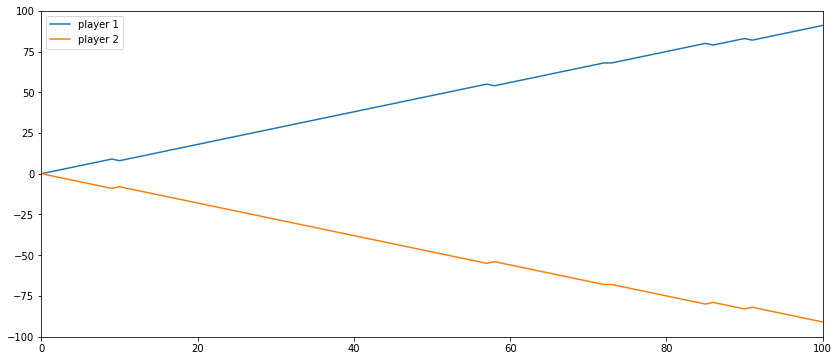

[[0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0,
  26.0,
  27.0,
  28.0,
  29.0,
  30.0,
  31.0,
  32.0,
  33.0,
  34.0,
  35.0,
  36.0,
  37.0,
  38.0,
  39.0,
  40.0,
  41.0,
  42.0,
  43.0,
  44.0,
  45.0,
  46.0,
  47.0,
  48.0,
  49.0,
  50.0,
  51.0,
  52.0,
  53.0,
  54.0,
  55.0,
  54.0,
  55.0,
  56.0,
  57.0,
  58.0,
  59.0,
  60.0,
  61.0,
  62.0,
  63.0,
  64.0,
  65.0,
  66.0,
  67.0,
  68.0,
  68.0,
  69.0,
  70.0,
  71.0,
  72.0,
  73.0,
  74.0,
  75.0,
  76.0,
  77.0,
  78.0,
  79.0,
  80.0,
  79.0,
  80.0,
  81.0,
  82.0,
  83.0,
  82.0,
  83.0,
  84.0,
  85.0,
  86.0,
  87.0,
  88.0,
  89.0,
  90.0,
  91.0],
 [0,
  -1.0,
  -2.0,
  -3.0,
  -4.0,
  -5.0,
  -6.0,
  -7.0,
  -8.0,
  -9.0,
  -8.0,
  -9.0,
  -10.0,
  -11.0,
  -12.0,
  -13.0,
  -14.0,
  -15.0,
  -16.0,
  -17.0,
  -18.0,
  -19.0,
  -20.0,
  -21.0,
  -2

In [ ]:
from open_spiel.python.algorithms import mcts
game = pyspiel.load_game("connect_four")
agent = MCTSAgent(game)
mcts_agent = mcts.MCTSBot(game, sqrt(2), 100, mcts.RandomRolloutEvaluator())
play_game(game, (agent, mcts_agent), 100, plot=True)